# Stochastic and worst-case robust approximation

The variation in matrix $A$ can be modeled using a set-based, worst-case approach. We describe the uncertainty by a set of possible values for $A$:

$$ A \in A' \subseteq R^{m \times n}$$

which we assume is nonempty and bounded. The *worst-case error* of a candidate approximate solution $x \in R^n$ is defined as

$$ e_{wc}(x) = \sup{\{||Ax-b||\ \ | A \in A'}\} $$

which is always a convex function of $x$. The *robust approximation problem* is to minimze the worst-case error:

$$ \min e_{wc}(x) = \sup{\{ ||Ax-b||\ \ |A\in A' \}} $$

where the variable is $x$, and the problem data are $b$ and the set $A'$. When $A'$ is the singleton $A'=\{A\}$, the robust approximation problem reduces to the basic norm approximation problem

$$ \min ||Ax-b|| $$

The robust approximation problem is always a convex optimization problem, but its tractability depends on the norm used and the description of the uncertainty set $A'$.

In [ ]:
from math import pi
from cvxopt import blas, lapack, solvers
from cvxopt import matrix, spmatrix, mul, cos, sin, sqrt, uniform
from pickle import load
solvers.options['show_progress'] = 0
try: import pylab, numpy
except ImportError: pylab_installed = False
else: 
  pylab_installed = True

In [ ]:
def wcls(A, Ap, b):
    """
    wcls --> Worst Case Least Squares
    Solves the robust least squares problem

        minimize sup_{||u||<= 1} || (A + sum_k u[k]*Ap[k])*x - b ||_2^2.

    A is mxn.  Ap is a list of mxn matrices.  b is mx1.
    """

    (m, n), p = A.size, len(Ap)

    # minimize    t + v
    # subject to  [ I         *     *  ]
    #             [ P(x)'     v*I  -*  ] >= 0.
    #             [ (A*x-b)'  0     t  ]
    #
    # where P(x) = [Ap[0]*x, Ap[1]*x, ..., Ap[p-1]*x].
    #
    # Variables x (n), v (1), t(1).

    novars = n + 2
    M = m + p + 1
    c = matrix( n*[0.0] + 2*[1.0])
    Fs = [spmatrix([],[],[], (M**2, novars))]
    for k in range(n):
        # coefficient of x[k]
        S = spmatrix([], [], [], (M, M))
        for j in range(p):
            S[m+j, :m] = -Ap[j][:,k].T
            S[-1, :m ] = -A[:,k].T
        Fs[0][:,k] = S[:]
    
    # coefficient of v
    Fs[0][(M+1)*m : (M+1)*(m+p) : M+1, -2] = -1.0
    
    # coefficient of t
    Fs[0][-1, -1] = -1.0

    hs = [matrix(0.0, (M, M))]
    hs[0][:(M+1)*m:M+1] = 1.0
    hs[0][-1, :m] = -b.T

    return solvers.sdp(c, None, None, Fs, hs)['x'][:n]

## Figure 6.15

First, we read the problem's data and create a vector on which the function will be tested on.

In this problem $u \in \mathbb{R}$ is an uncertain parameter and $A(u)=A_0 + uA_1$
$A(u) \in \mathbb{R}^{20 \times 10}$, $||A_0||=10$, $||A_1=1$, and $u\in[-1,1]$

In [ ]:
data = load(open('/content/drive/MyDrive/Optimizacion_Convexa/03_Applications_to_modelling/robls.bin','rb'))['6.15']
A, b, B = data['A'], data['b'], data['B']
m, n = A.size

# Vector creation
nopts = 500
us = -2.0 + (2.0 - (-2.0))/(nopts-1) * matrix(list(range(nopts)),tc='d')

### Nominal problem: minimize $ ||Ax-b||_2$

In [ ]:
xnom = +b
lapack.gels(+A, xnom)
xnom = xnom[:n]
rnom = [ blas.nrm2( (A+u*B)*xnom - b) for u in us ]

### Stochastic problem
$ \min E||(A + uB)x - b||_2^2 = ||aX-B||_2^2 + x'Px $

with $ P = E(u^2)B'B = \frac{1}{3}B'B $ 

In [ ]:
# Stochastic problem.
#
# minimize E || (A+u*B) * x - b ||_2^2
#          = || A*x - b||_2^2 + x'*P*x
#
# with P = E(u^2) * B'*B = (1/3) * B'*B
S = A.T * A + (1.0/3.0) * B.T * B
xstoch = A.T * b
lapack.posv(S, xstoch)
# Stochastic approximation
rstoch = [ blas.nrm2( (A+u*B)*xstoch - b) for u in us ]

### Worst case approximation
$$ \min \max_{-1 \leq u \leq 1} ||Au-b||_2^2$$

In [ ]:
# Worst case approximation.
#
# minimize max_{-1 <= u <= 1} ||A*u - b||_2^2.
xwc = wcls(A, [B], b)
rwc = [ blas.nrm2( (A+u*B)*xwc - b) for u in us ]

The residual is plotted for each of the $x$, rewritten as a function of $u$.
$$ r(u) = ||A(u)x-b||_2 $$

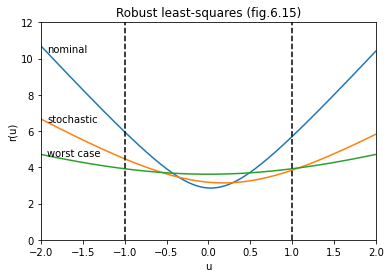

In [ ]:
if pylab_installed:
    pylab.figure(1, facecolor='w')
    pylab.plot(us, rnom, us, rstoch, us, rwc)
    pylab.plot([-1, -1], [0, 12], '--k', [1, 1], [0, 12], '--k')
    pylab.axis([-2.0, 2.0, 0.0, 12.0])
    pylab.xlabel('u')
    pylab.ylabel('r(u)')
    pylab.text(us[9], rnom[9], 'nominal')
    pylab.text(us[9], rstoch[9], 'stochastic')
    pylab.text(us[9], rwc[9], 'worst case')
    pylab.title('Robust least-squares (fig.6.15)')

The residual $ r(u) = ||A(u)x-b||_2 $ as a function of the uncertain parameter $u$ for three approximate solutions


1.   the nominal least-squares solution $x_{nom}$
2.   the solution of the stochastic robust approximation problem $x_{stock}$
3.   the solution of the worst-case robust approximation problem $x_{wc}$

where $u\in[-1,1]$.

The nominal solution achieves the smallest residual when $u=0$, but gives much larger residuals as $u$ approaches $-1$ or $1$. The worst-cast solution has a larger residual at $0$, but the residuals do not increase as much when $u$ varies over its interval. The stochastic solution is in-between.


## Figure 6.16

A comparison of worst-case robust, Tikhonov regularized, and nominal least-squares solutions. Consider the following optimization problem:
$$ \min \sup_{||u||_2 \leq 1} ||(\overline{A}+ u_1 A_1 + u_2 A_2)x - b||_2$$
$m=50$, $n=20$, matrix $\overline{A}$ has norm 10, and $A1$ & $A2$ have norm 1.
$u_1$ and $u2$ lie in the unit disk $\mathbb{R}^2$.

In [ ]:
data = load(open('/content/drive/MyDrive/Optimizacion_Convexa/03_Applications_to_modelling/robls.bin','rb'))['6.16']
A, Ap, b = data['A0'], [data['A1'], data['A2']], data['b']
(m, n), p = A.size, len(Ap)

notrials = 100000
r = sqrt(uniform(1,notrials))
theta = 2.0 * pi * uniform(1,notrials)
u = matrix(0.0, (2,notrials))
u[0,:] = mul(r, cos(theta))
u[1,:] = mul(r, sin(theta))

### Least squares solution
$ \min ||Ax-b||_2^2 $

In [ ]:
xls = +b
lapack.gels(+A, xls)
xls = xls[:n]

q = A*xls - b
P = matrix(0.0, (m,2))
P[:,0], P[:,1] = Ap[0]*xls, Ap[1]*xls
r = P*u + q[:,notrials*[0]]
resls = sqrt( matrix(1.0, (1,m)) * mul(r,r) )

### Tikhonov solution
$ \min ||Ax-b||_2^2 + 0.1||x||_2^2 $

In [ ]:
xtik = A.T*b
S = A.T*A
S[::n+1] += 0.1
lapack.posv(S, xtik)

q = A*xtik - b
P[:,0], P[:,1] = Ap[0]*xtik, Ap[1]*xtik
r = P*u + q[:,notrials*[0]]
restik = sqrt( matrix(1.0, (1,m)) * mul(r,r) )

### Worst case solution


In [ ]:
xwc = wcls(A, Ap, b)

q = A*xwc - b
P[:,0], P[:,1] = Ap[0]*xwc, Ap[1]*xwc
r = P*u + q[:,notrials*[0]]
reswc = sqrt( matrix(1.0, (1,m)) * mul(r,r) )

The sensitivity of $u$ is shown by playing around with $10^5$ parameter vectors, uniformly distributed on the unit disk, which are evaluated on the residual
$$ ||(A_0+ u_1 A_1 + u_2 A_2)x - b||_2 $$

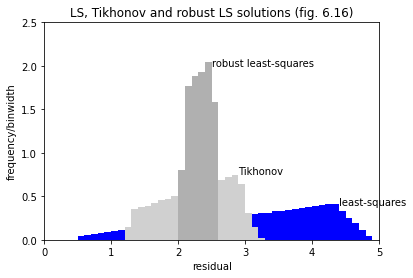

In [ ]:
if pylab_installed:
   pylab.figure(2, facecolor='w')
   pylab.hist(list(resls), numpy.array([0.1*k for k in range(50)]), fc='b',
       density=True)
   pylab.text(4.4, 0.4, 'least-squares')
   pylab.hist(list(restik), numpy.array([0.1*k for k in range(50)]), fc='#D0D0D0',
       density=True)
   pylab.text(2.9, 0.75, 'Tikhonov')
   pylab.hist(list(reswc), numpy.array([0.1*k for k in range(50)]), fc='#B0B0B0',
       density=True)
   pylab.text(2.5, 2.0, 'robust least-squares')
   pylab.xlabel('residual')
   pylab.ylabel('frequency/binwidth')
   pylab.axis([0, 5, 0, 2.5])
   pylab.title('LS, Tikhonov and robust LS solutions (fig. 6.16)')
   pylab.show()

# Reference

https://cvxopt.org/examples/book/robls.html
